In [20]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud

nltk.download('stopwords')

analyzer = SentimentIntensityAnalyzer()
stop_words = stopwords.words("english")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\YODAHE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
df = pd.read_csv("../data/processed/reviews_clean.csv")
df.head()


,bank,app_name,review,rating,date,source
0,CBE,CBE Mobile Banking,CBE ይለያል።,5,2025-11-29,google-play
1,CBE,CBE Mobile Banking,it's special for me,5,2025-11-29,google-play
2,CBE,CBE Mobile Banking,Make it user friendly.,2,2025-11-29,google-play
3,CBE,CBE Mobile Banking,maaliif daddafee install gaafata,3,2025-11-28,google-play
4,CBE,CBE Mobile Banking,good app,5,2025-11-28,google-play


In [23]:
def get_vader_sentiment(text):
    score = analyzer.polarity_scores(str(text))
    
    if score["compound"] >= 0.05:
        label = "positive"
    elif score["compound"] <= -0.05:
        label = "negative"
    else:
        label = "neutral"
    
    return pd.Series([label, score["compound"]])

df[['sentiment_label', 'sentiment_score']] = df['review'].apply(get_vader_sentiment)
df.head()


,bank,app_name,review,rating,date,source,sentiment_label,sentiment_score
0,CBE,CBE Mobile Banking,CBE ይለያል።,5,2025-11-29,google-play,neutral,0.0000
1,CBE,CBE Mobile Banking,it's special for me,5,2025-11-29,google-play,positive,0.4019
2,CBE,CBE Mobile Banking,Make it user friendly.,2,2025-11-29,google-play,positive,0.4939
3,CBE,CBE Mobile Banking,maaliif daddafee install gaafata,3,2025-11-28,google-play,neutral,0.0000
4,CBE,CBE Mobile Banking,good app,5,2025-11-28,google-play,positive,0.4404


In [24]:
sentiment_counts = df.groupby(["bank", "sentiment_label"]).size().unstack().fillna(0)
sentiment_counts


sentiment_label,negative,neutral,positive
bank,,,
BOA,264,318,308
CBE,780,1920,3249
Dashen,71,141,387


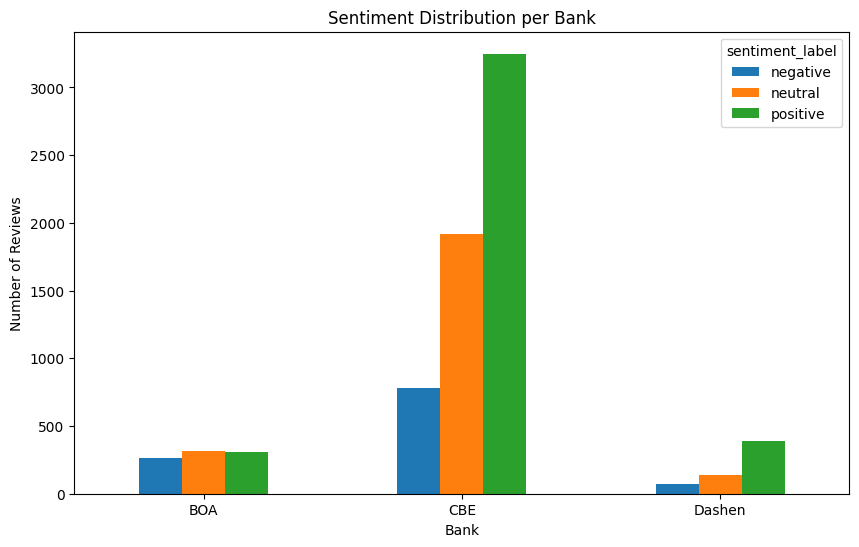

In [25]:
sentiment_counts.plot(kind="bar", figsize=(10,6))
plt.title("Sentiment Distribution per Bank")
plt.xlabel("Bank")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.show()


In [26]:
tfidf = TfidfVectorizer(max_features=30, stop_words="english")
tfidf_matrix = tfidf.fit_transform(df["review"])
keywords = tfidf.get_feature_names_out()
keywords


array(['account', 'app', 'application', 'bank', 'banking', 'best',
       'better', 'cbe', 'doesn', 'easy', 'ethiopia', 'fast', 'fix',
       'good', 'great', 'like', 'make', 'mobile', 'money', 'need', 'new',
       'nice', 'service', 'time', 'transaction', 'transfer', 'update',
       'use', 'work', 'working'], dtype=object)

In [28]:
bank_keywords = {}

for bank in df['bank'].unique():
    bank_df = df[df['bank'] == bank]
    bank_tfidf = TfidfVectorizer(max_features=20, stop_words="english")
    bank_keywords[bank] = bank_tfidf.fit(bank_df['review']).get_feature_names_out()

bank_keywords


{'CBE': array(['account', 'app', 'application', 'bank', 'banking', 'best', 'cbe',
        'easy', 'good', 'like', 'mobile', 'money', 'nice', 'time',
        'transaction', 'transfer', 'update', 'use', 'work', 'working'],
       dtype=object),
 'BOA': array(['app', 'application', 'bank', 'banking', 'best', 'boa',
        'developer', 'doesn', 'fix', 'good', 'like', 'mobile', 'money',
        'time', 'update', 'use', 'version', 'work', 'working', 'worst'],
       dtype=object),
 'Dashen': array(['amazing', 'app', 'application', 'bank', 'banking', 'best',
        'dashen', 'easy', 'experience', 'fast', 'features', 'friendly',
        'good', 'great', 'like', 'mobile', 'step', 'super', 'use', 'user'],
       dtype=object)}

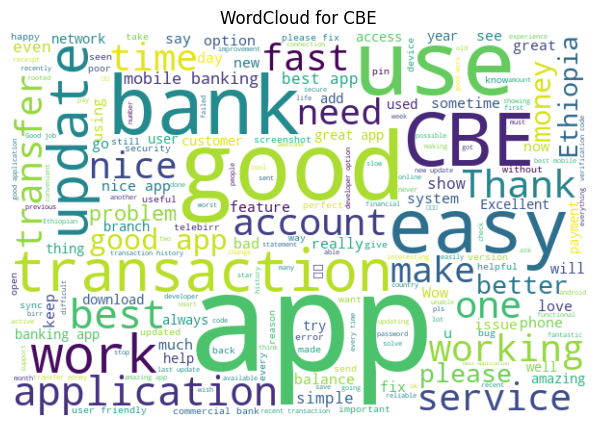

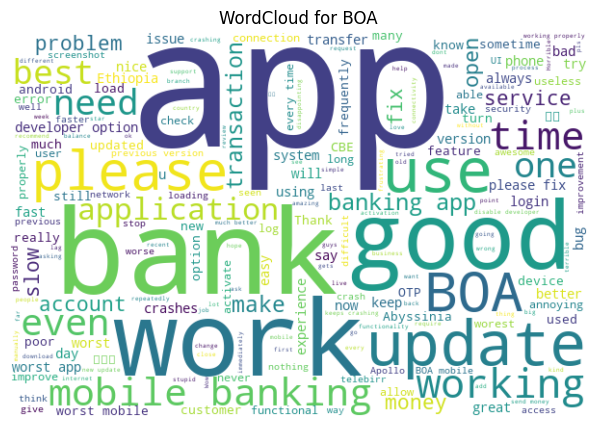

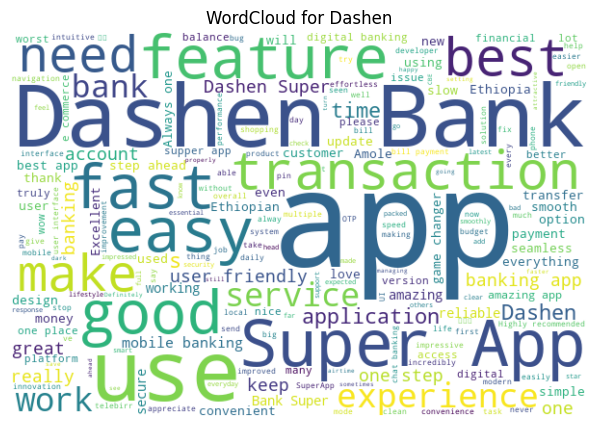

In [29]:
for bank in df['bank'].unique():
    text = " ".join(df[df['bank']==bank]["review"].astype(str))
    wc = WordCloud(width=600, height=400, background_color="white").generate(text)

    plt.figure(figsize=(8,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for {bank}")
    plt.show()


In [30]:
THEMES = {
    "Login Issues": ["login", "password", "otp", "authentication"],
    "Performance & Speed": ["slow", "lag", "freeze", "loading"],
    "Crashes & Errors": ["crash", "error", "bug", "fail"],
    "User Interface": ["ui", "design", "layout", "interface"],
    "Feature Requests": ["feature", "add", "missing", "option"],
}

def assign_themes(text):
    text = str(text).lower()
    found = []

    for theme, words in THEMES.items():
        if any(word in text for word in words):
            found.append(theme)

    if not found:
        return "Other"
    
    return ", ".join(found)

df["themes"] = df["review"].apply(assign_themes)
df.head()


,bank,app_name,review,rating,date,source,sentiment_label,sentiment_score,themes
0,CBE,CBE Mobile Banking,CBE ይለያል።,5,2025-11-29,google-play,neutral,0.0000,Other
1,CBE,CBE Mobile Banking,it's special for me,5,2025-11-29,google-play,positive,0.4019,Other
2,CBE,CBE Mobile Banking,Make it user friendly.,2,2025-11-29,google-play,positive,0.4939,Other
3,CBE,CBE Mobile Banking,maaliif daddafee install gaafata,3,2025-11-28,google-play,neutral,0.0000,Feature Requests
4,CBE,CBE Mobile Banking,good app,5,2025-11-28,google-play,positive,0.4404,Other


In [31]:
theme_counts = df.groupby(["bank", "themes"]).size().unstack().fillna(0)
theme_counts


themes,Crashes & Errors,"Crashes & Errors, Feature Requests","Crashes & Errors, User Interface","Crashes & Errors, User Interface, Feature Requests",Feature Requests,Login Issues,"Login Issues, Crashes & Errors","Login Issues, Crashes & Errors, Feature Requests","Login Issues, Crashes & Errors, User Interface","Login Issues, Crashes & Errors, User Interface, Feature Requests",...,Other,Performance & Speed,"Performance & Speed, Crashes & Errors","Performance & Speed, Crashes & Errors, Feature Requests","Performance & Speed, Crashes & Errors, User Interface, Feature Requests","Performance & Speed, Feature Requests","Performance & Speed, User Interface","Performance & Speed, User Interface, Feature Requests",User Interface,"User Interface, Feature Requests"
bank,,,,,,,,,,,,,,,,,,,,,
BOA,66.0,3.0,1.0,1.0,43.0,18.0,5.0,2.0,2.0,1.0,...,664.0,39.0,4.0,2.0,1.0,5.0,3.0,0.0,14.0,5.0
CBE,179.0,12.0,18.0,2.0,241.0,41.0,5.0,0.0,1.0,1.0,...,5260.0,47.0,2.0,0.0,0.0,10.0,1.0,1.0,93.0,21.0
Dashen,8.0,1.0,2.0,2.0,51.0,6.0,2.0,0.0,0.0,0.0,...,450.0,18.0,3.0,0.0,0.0,5.0,1.0,0.0,28.0,18.0


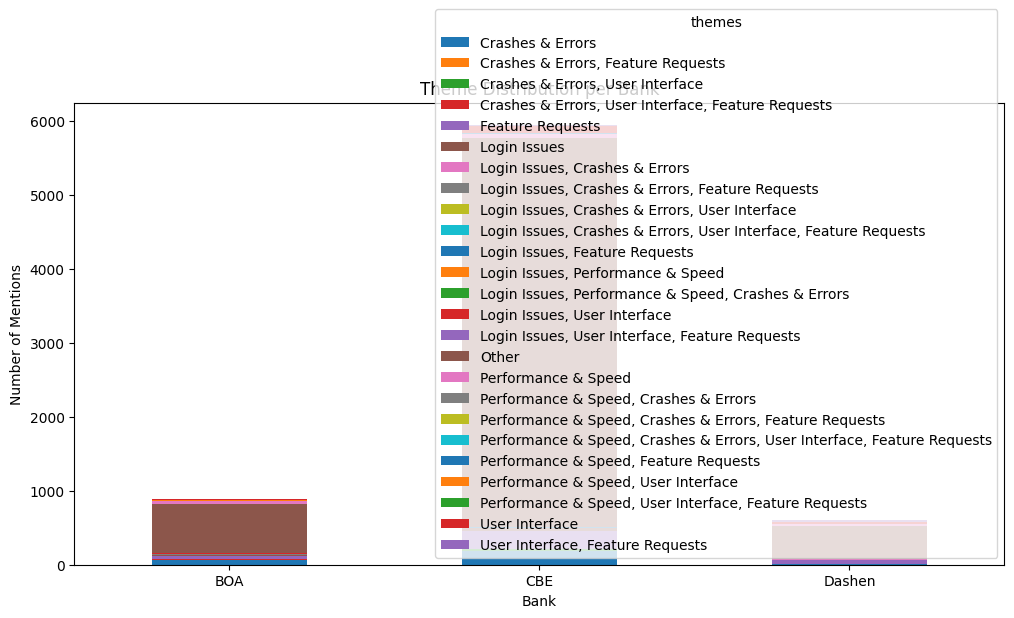

In [32]:
theme_counts.plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Theme Distribution per Bank")
plt.xlabel("Bank")
plt.ylabel("Number of Mentions")
plt.xticks(rotation=0)
plt.show()


In [33]:
df.to_csv("../data/processed/reviews_task2_with_sentiment_and_themes.csv", index=False)
print("Saved Task-2 output to data/processed/")


Saved Task-2 output to data/processed/
